In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import yfinance as yf
import warnings
warnings.filterwarnings('ignore')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Initializing strategy...

Running strategy without overnight filter...
Fetching data...
Calculating moving averages...
Generating signals...
Backtesting strategy...
Calculating performance metrics...
Plotting results...

Performance Metrics (Without Overnight Filter):
                          base_strategy  SPY_Strategy  VIX_Strategy  \
Annualized Return              0.132717      0.142911      0.105601   
Annualized Volatility          0.126440      0.058264      0.059951   
Sharpe Ratio                   1.049646      2.452822      1.761452   
Average Daily Return           0.000527      0.000537      0.000406   
Average Daily Volatility       0.007965      0.003670      0.003777   
Maximum Drawdown              -0.196376     -0.024919     -0.062111   
CAR/Max DD                     0.675832      5.735128      1.700196   

                          BSI_Strategy  Combined_Strategy  
Annualized Return             0.067298           0.105315  
Annualized Volatility         0.057743    

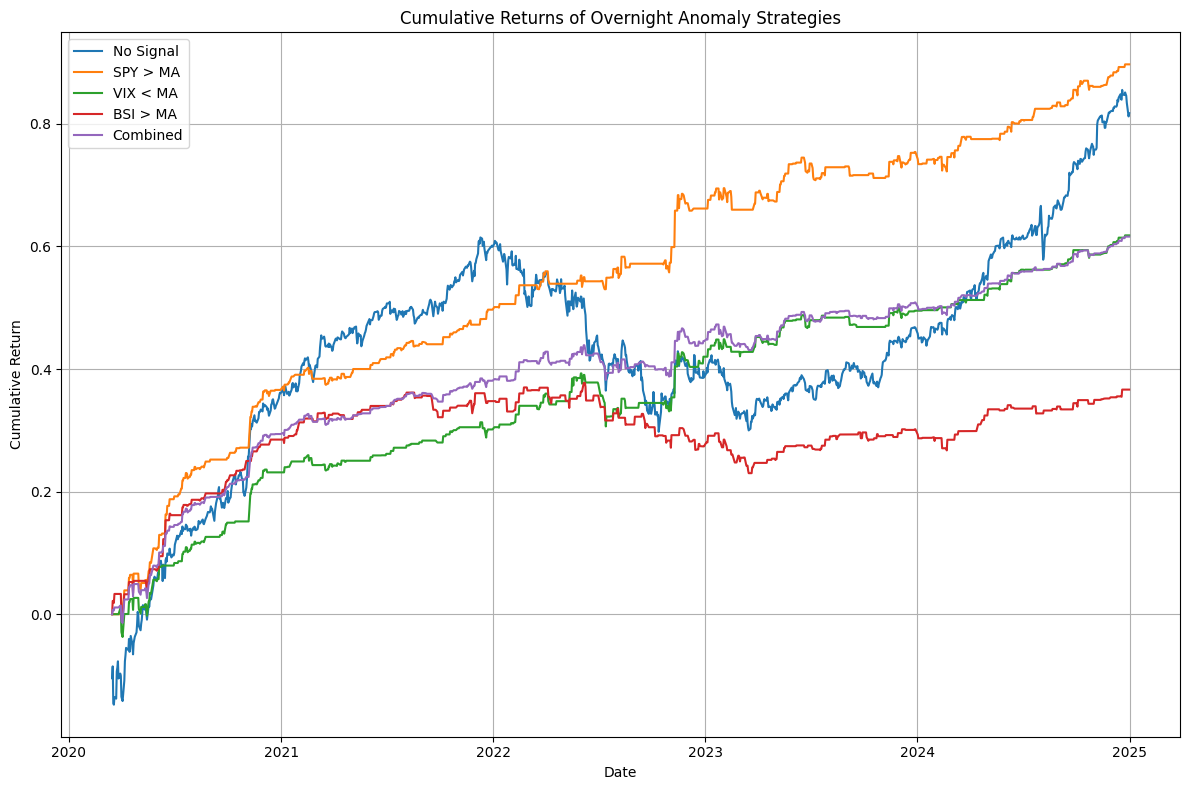

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Initializing strategy with overnight filter...

Running strategy with overnight filter...
Fetching data...
Calculating moving averages...
Generating signals...
Backtesting strategy...
Calculating performance metrics...
Plotting results...

Performance Metrics (With Overnight Filter):
                          base_strategy  SPY_Strategy  VIX_Strategy  \
Annualized Return              0.132717      0.262366      0.221683   
Annualized Volatility          0.126440      0.080552      0.078207   
Sharpe Ratio                   1.049646      3.257102      2.834583   
Average Daily Return           0.000527      0.000938      0.000807   
Average Daily Volatility       0.007965      0.005074      0.004927   
Maximum Drawdown              -0.196376     -0.053743     -0.063818   
CAR/Max DD                     0.675832      4.881897      3.473688   

                          BSI_Strategy  Combined_Strategy  
Annualized Return             0.065542           0.181428  
Annualized Volatility    

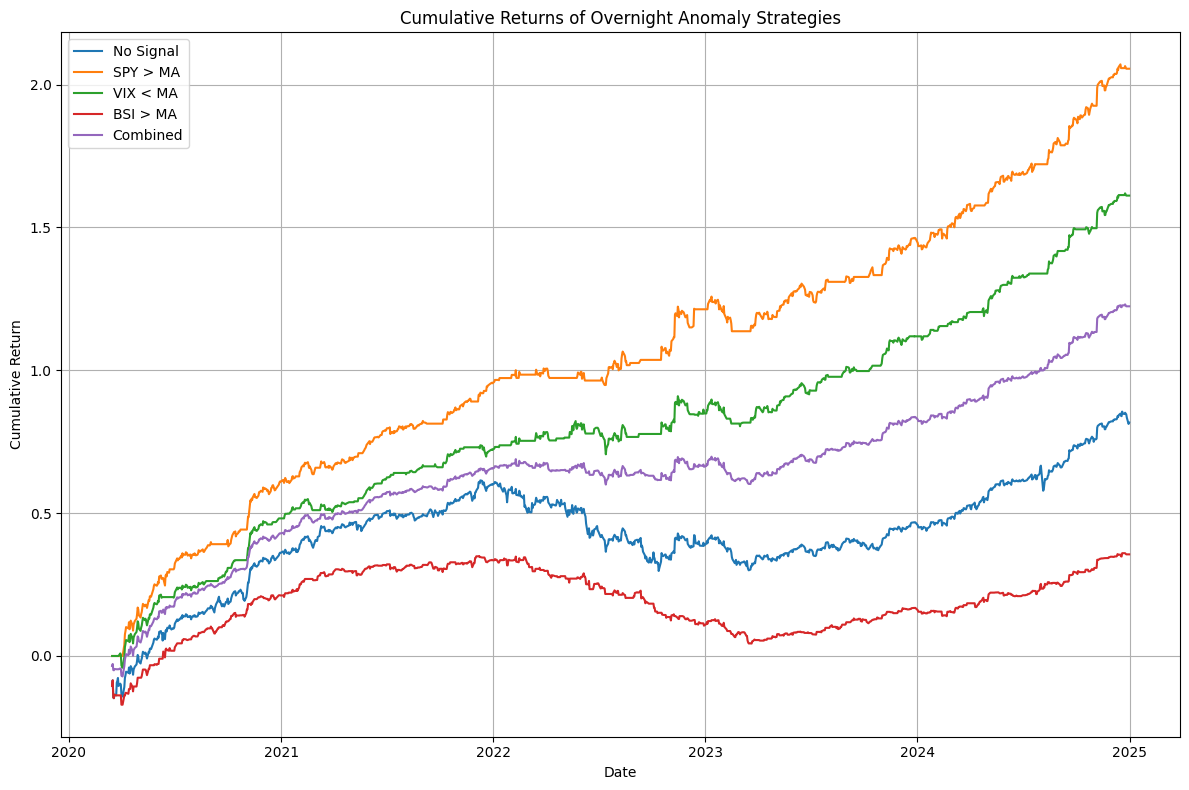

In [9]:
class OvernightAnomalyStrategy:

  def __init__(self,ticker='SPY',start_date='2020-01-01',end_date=None):
    self.ticker=ticker
    self.start_date=start_date
    self.end_date=end_date if end_date else datetime.now().strftime('%Y-%m-%d')
    self.data=None
    self.results={}


  def fetch_data(self):
    spy_data=yf.download(self.ticker,start=self.start_date,end=self.end_date)
    vix_data=yf.download('^VIX',start=self.start_date,end=self.end_date)

    common_dates=spy_data.index.intersection(vix_data.index)#ensuring alignment between SPY and VIX

    #only including records of common dates
    spy_data=spy_data.loc[common_dates]
    vix_data=vix_data.loc[common_dates]

    self.data=pd.DataFrame(index=common_dates)

    for col in ['Open','High','Low','Close']:
      self.data[col]=spy_data[col]

    self.data['VIX_Close']=vix_data['Close']

    #currently no data for BSI, simulating it
    np.random.seed(42)
    self.data['BSI']=np.random.uniform(0,100,len(self.data))

    #overnight and intraday returns
    self.data['Overnight_return']=(self.data['Open']/self.data['Close'].shift(1))-1
    self.data['intraday_returns']=(self.data['Close']/self.data['Open'])-1
    self.data['daily_returns']=(self.data['Close']/self.data['Close'].shift(1))-1

    self.data=self.data.dropna()

    return self.data

  def calculate_moving_average(self,periods=[20,50]):
    temp_data=self.data.copy()

    for period in periods:
      temp_data[f'SPY_MA_{period}']=temp_data['Close'].rolling(window=period).mean()
      temp_data[f'VIX_MA_{period}']=temp_data['VIX_Close'].rolling(window=period).mean()
      temp_data[f'BSI_MA_{period}']=temp_data['BSI'].rolling(window=period).mean()

    self.data=temp_data.dropna()
    return self.data

  def generate_signals(self,ma_period=20):
    temp_data=self.data.copy()

    #generating signals
    temp_data['SPY_Signal']=np.where(temp_data['Close']>temp_data[f'SPY_MA_{ma_period}'],1,0)
    temp_data['VIX_Signal']=np.where(temp_data['VIX_Close']<temp_data[f'VIX_MA_{ma_period}'],1,0)
    temp_data['BSI_Signal']=np.where(temp_data['BSI']>temp_data[f'BSI_MA_{ma_period}'],1,0)

    #combining signals
    temp_data['Combined Signal']=(temp_data['SPY_Signal']+temp_data['VIX_Signal']+temp_data['BSI_Signal'])/3

    temp_data['Previous_Overnight_Negative']=np.where(temp_data['Overnight_return'].shift(1)<0,1,0)
    self.data=temp_data.fillna(0)
    return self.data

  def backtest_strategy(self,ma_period=20,use_overnight_filter=False):
    temp_data=self.data.copy()
    temp_data['base_strategy']=temp_data['Overnight_return'] #base strategy: always invest overnight

    #SPY Signal strat
    if not use_overnight_filter:
      temp_data['SPY_Strategy']=np.where((temp_data['SPY_Signal']==1) & temp_data['Previous_Overnight_Negative']==1,temp_data['Overnight_return'],0)#overnight investing, only trade the signal after a down night(hoping for mean reversion)
    else:
      temp_data['SPY_Strategy']=np.where(temp_data['SPY_Signal']==1,temp_data['Overnight_return'],0)#trade irrespective of what happened overnight

    #VIX Signal strat
    if not use_overnight_filter:
      temp_data['VIX_Strategy']=np.where((temp_data['VIX_Signal']==1) & temp_data['Previous_Overnight_Negative']==1,temp_data['Overnight_return'],0)# only trade the signal after a down night(hoping for mean reversion)
    else:
      temp_data['VIX_Strategy']=np.where(temp_data['VIX_Signal']==1,temp_data['Overnight_return'],0)

    #BSI signal strat
    if not use_overnight_filter:
      temp_data['BSI_Strategy']=np.where((temp_data['BSI_Signal']==1) & temp_data['Previous_Overnight_Negative']==1,temp_data['Overnight_return'],0)# only trade the signal after a down night(hoping for mean reversion)
    else:
      temp_data['BSI_Strategy']=np.where((temp_data['BSI_Signal']==1),temp_data['Overnight_return'],0)

    #COMBINED STRATEGY
    strategy_columns=['SPY_Strategy','VIX_Strategy','BSI_Strategy']
    temp_data['Combined_Strategy']=temp_data[strategy_columns].mean(axis=1)

    #cumulative returns
    all_strategy_columns=['base_strategy','SPY_Strategy','VIX_Strategy','BSI_Strategy','Combined_Strategy']
    for strategy in all_strategy_columns:
      temp_data[f'{strategy}_cum_returns']=(1+temp_data[strategy]).cumprod()-1

    self.data=temp_data
    return self.data

  def calculate_performance_metrics(self):
        strategy_columns = ['base_strategy', 'SPY_Strategy', 'VIX_Strategy',
                           'BSI_Strategy', 'Combined_Strategy']

        results = {}
        trading_days = 252  # Typical number of trading days in a year

        for col in strategy_columns:
            # Calculate metrics
            returns = self.data[col].fillna(0)
            cum_returns = self.data[f'{col}_cum_returns'].fillna(0)

            # Number of years
            years = len(returns) / trading_days

            # Annualized return
            ann_return = (1 + cum_returns.iloc[-1]) ** (1 / years) - 1

            # Annualized volatility
            ann_vol = returns.std() * np.sqrt(trading_days)

            # Sharpe ratio (assuming risk-free rate of 0)
            sharpe = ann_return / ann_vol if ann_vol > 0 else 0

            # Average daily return
            avg_daily_return = returns.mean()

            # Average daily volatility
            avg_daily_vol = returns.std()

            # Maximum drawdown
            cumulative = (1 + returns).cumprod()
            running_max = cumulative.cummax()
            drawdown = (cumulative / running_max) - 1
            max_drawdown = drawdown.min()

            # CAR/Max DD
            car_max_dd = abs(ann_return / max_drawdown) if max_drawdown != 0 else np.inf

            results[col] = {
                'Annualized Return': ann_return,
                'Annualized Volatility': ann_vol,
                'Sharpe Ratio': sharpe,
                'Average Daily Return': avg_daily_return,
                'Average Daily Volatility': avg_daily_vol,
                'Maximum Drawdown': max_drawdown,
                'CAR/Max DD': car_max_dd
            }

        self.results = results
        return pd.DataFrame(results)

  def plot_results(self):

        plt.figure(figsize=(12, 8))

        strategy_columns = ['base_strategy_cum_returns', 'SPY_Strategy_cum_returns',
                            'VIX_Strategy_cum_returns', 'BSI_Strategy_cum_returns',
                            'Combined_Strategy_cum_returns']

        labels = ['No Signal', 'SPY > MA', 'VIX < MA', 'BSI > MA', 'Combined']

        for col, label in zip(strategy_columns, labels):
            plt.plot(self.data.index, self.data[col], label=label)

        plt.title('Cumulative Returns of Overnight Anomaly Strategies')
        plt.xlabel('Date')
        plt.ylabel('Cumulative Return')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()

        return plt

  def run_strategy(self, ma_period=20, use_overnight_filter=False):

        print("Fetching data...")
        self.fetch_data()
        print("Calculating moving averages...")
        self.calculate_moving_average()
        print("Generating signals...")
        self.generate_signals(ma_period)
        print("Backtesting strategy...")
        self.backtest_strategy(ma_period, use_overnight_filter)
        print("Calculating performance metrics...")
        metrics = self.calculate_performance_metrics()
        print("Plotting results...")

        return {
            'data': self.data,
            'metrics': metrics,
            'plot': self.plot_results()
        }


# Example
if __name__ == "__main__":
    print("Initializing strategy...")


    strategy = OvernightAnomalyStrategy(
        ticker="SPY",
        start_date="2020-01-01",
        end_date="2025-01-01"
    )

    # Run the strategy with 20-day MA without overnight filter
    print("\nRunning strategy without overnight filter...")
    results_without_filter = strategy.run_strategy(ma_period=20, use_overnight_filter=False)

    # performance metrics
    print("\nPerformance Metrics (Without Overnight Filter):")
    print(results_without_filter['metrics'])

    # Showing plot
    results_without_filter['plot'].show()

    # Run the strategy with 20-day MA with overnight filter
    print("\nInitializing strategy with overnight filter...")
    strategy = OvernightAnomalyStrategy(
        ticker="SPY",
        start_date="2020-01-01",
        end_date="2025-01-01"
    )

    print("\nRunning strategy with overnight filter...")
    results_with_filter = strategy.run_strategy(ma_period=20, use_overnight_filter=True)

    # Print performance metrics
    print("\nPerformance Metrics (With Overnight Filter):")
    print(results_with_filter['metrics'])

    # Show the plot
    results_with_filter['plot'].show()